# Analisi su come i tecnici della Serie A 2022-23 utilizzano le 5 sostituzioni a disposizione
### Con questo notebook voglio analizzare un aspetto sempre più importante da quando c'è stato il cambio di regolamento che ha portato a 5 il numero di sostituzioni consentite ad ogni squadra durante una partita. Come hanno sfruttato questa possibilità i vari tecnici di Serie A finora? Chi ne ha tratto più beneficio? Solo 3 squadre hanno utilizzato tutti i 45 possibili cambi (U.S. Cremonese , ACF Fiorentina e Società Sportiva Calcio Napoli) mentre Mourinho in media ne utilizza (solo) 4 a partita. Questi cambi sono tutti concentrati nel secondo tempo e in particolare dopo il 60° minuto: la AS Roma e la Juventus Football Club sono le squadre che ritardano di più (mediana rispettivamente al min. 77 e 76) e congiuntamente quelle che ottengono meno dai cambi (1 solo goal non decisivo per la Juventus), l'Empoli Football Club invece quella che li effettua mediamente prima di tutte le altre (min. 65). Come influiscono questi cambi? Beh l' Udinese Calcio, Napoli e S.S. Lazio sono le squadre con più reti segnate da subentrati e con la bellezza di 4, 2 e 1 goal decisivi rispettivamente (forte correlazione con le prime posizioni della classifica di Serie A). Come bomber dalla panchina è doveroso segnalare Luis Alberto con 3 goal e Simeone 2 (entrambi decisivi).

In [1]:
import pandas as pd
import numpy as np
import requests
from requests.auth import HTTPBasicAuth

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as path_effects
import matplotlib.font_manager as fm
from matplotlib import rcParams
import seaborn as sns

from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import ipywidgets
from ipywidgets import widgets
from IPython.display import clear_output

from PIL import Image
import urllib

import plotly.graph_objects as go
from highlight_text import fig_text

import os
import json

atalanta = [59, 67, 72, 52, 81, 89, 52, 65, 85, 85, 85, 46, 46, 46, 67, 67, 46, 73, 73, 85, 88, 36, 60, 61, 70, 70, 46, 55, 55, 60, 70, 62, 73, 73, 83, 83, 46, 71, 71, 86, 86]
bologna = [46, 65, 65, 73, 86, 64, 64, 89, 62, 62, 62, 74, 84, 46, 46, 46, 74, 81, 46, 62, 62, 76, 84, 61, 70, 79, 79, 57, 57, 79, 79, 88, 61, 61, 61, 77, 77, 18, 73, 73, 79, 79]
cremonese = [46, 46, 65, 82, 87, 56, 56, 56, 78, 85, 62, 62, 69, 85, 85, 46, 67, 67, 67, 81, 61, 61, 76, 76, 83, 60, 68, 68, 83, 83, 28, 46, 46, 63, 80, 65, 65, 74, 74, 83, 46, 62, 72, 72, 80]
empoli = [54, 72, 88, 63, 63, 67, 67, 86, 56, 56, 65, 73, 73, 38, 64, 64, 83, 83, 57, 57, 66, 77, 77, 52, 63, 63, 82, 82, 57, 65, 65, 79, 79, 45, 58, 58, 82, 83, 46, 46, 69, 78, 78]
fiorentina = [71, 71, 78, 78, 86, 46, 46, 76, 86, 87, 59, 69, 69, 80, 80, 68, 68, 80, 86, 86, 54, 62, 62, 79, 79, 45, 46, 72, 85, 85, 50, 66, 66, 79, 79, 67, 68, 75, 85, 86, 46, 58, 58, 72, 72]
juventus = [61, 61, 66, 76, 76, 46, 61, 77, 85, 58, 77, 77, 85, 86, 43, 54, 54, 85, 85, 46, 63, 63, 78, 83, 46, 62, 62, 78, 85, 78, 86, 86, 60, 60, 77, 77, 81, 46, 56, 56, 78, 80]
inter = [57, 57, 67, 67, 88, 68, 68, 75, 75, 84, 69, 69, 69, 77, 77, 55, 72, 72, 79, 79, 63, 63, 64, 84, 84, 68, 68, 77, 77, 85, 31, 31, 67, 67, 79, 77, 78, 81, 81, 88, 46, 58, 68, 84]
lazio = [8, 65, 83, 83, 83, 62, 62, 71, 83, 83, 57, 57, 71, 84, 84, 41, 72, 72, 73, 81, 53, 53, 75, 84, 84, 55, 65, 65, 76, 57, 57, 66, 78, 78, 46, 64, 64, 73, 77, 62, 72, 79, 79]
lecce = [64, 74, 74, 74, 46, 70, 80, 80, 90, 46, 69, 74, 79, 79, 46, 62, 62, 70, 75, 46, 65, 65, 74, 84, 46, 62, 63, 76, 82, 66, 66, 73, 78, 78, 46, 60, 70, 70, 84, 46, 71, 71, 81, 90]
milan = [71, 71, 72, 84, 84, 58, 58, 66, 66, 84, 61, 61, 61, 75, 83, 57, 57, 57, 73, 79, 63, 72, 72, 83, 83, 59, 71, 78, 46, 46, 66, 66, 82, 33, 39, 72, 73, 73, 58, 64, 64, 84, 84]
monza = [63, 64, 64, 76, 76, 46, 48, 58, 83, 83, 61, 61, 70, 80, 80, 46, 62, 62, 62, 84, 76, 76, 86, 86, 46, 58, 59, 59, 88, 54, 54, 55, 69, 85, 61, 71, 71, 83, 83, 56, 56, 74, 74, 84]
napoli = [68, 76, 76, 83, 83, 70, 70, 78, 78, 84, 61, 61, 71, 78, 78, 46, 46, 56, 71, 85, 45, 68, 68, 92, 92, 46, 57, 57, 67, 75, 66, 66, 87, 87, 91, 62, 62, 68, 80, 80, 57, 73, 73, 82, 82]
roma = [68, 78, 88, 72, 72, 86, 46, 46, 62, 78, 93, 28, 65, 65, 80, 80, 46, 46, 65, 77, 81, 81, 81, 95, 96, 67, 79, 87,58, 81, 86, 46, 46, 50, 77, 88]
salernitana = [54, 62, 62, 73, 46, 46, 89, 46, 65, 78, 78, 81, 54, 63, 76, 56, 56, 71, 82, 82, 61, 81, 81, 100, 100, 46, 46, 66, 76, 82, 46, 46, 59, 81, 81, 9, 59, 59, 90, 90]
sampdoria = [58, 58, 58, 75, 90, 67, 72, 72, 78, 78, 62, 62, 63, 63, 80, 46, 61, 69, 69, 73, 59, 59, 72, 72, 79, 59, 78, 78, 86, 46, 61, 73, 81, 82, 57, 57, 68, 68, 74, 46, 58, 69, 83]
sassuolo = [7, 46, 59, 80, 80, 63, 63, 80, 95, 69, 77, 78, 52, 69, 69, 84, 84, 55, 75, 75, 82, 46, 68, 68, 81, 92, 66, 66, 86, 46, 59, 67, 67, 80, 71, 71, 82, 82, 89]
spezia = [61, 75, 75, 91, 91, 67, 67, 79, 89, 89, 46, 58, 66, 78, 60, 60, 72, 85, 85, 64, 76, 88, 88, 62, 70, 70, 81, 59, 71, 71, 87, 87, 65, 65, 66, 75, 81, 59, 59, 69, 69, 80]
torino = [46, 70, 79, 90, 72, 72, 74, 82, 56, 69, 85, 85, 46, 67, 76, 64, 64, 81, 81, 69, 69, 77, 90, 90, 58, 58, 58, 78, 68, 74, 74, 85, 85, 67, 67, 74, 74, 88]
udinese = [67, 67, 76, 76, 83, 24, 46, 68, 80, 68, 68, 69, 81, 81, 43, 65, 65, 79, 79, 17, 63, 63, 64, 85, 46, 46, 67, 67, 81, 61, 68, 68, 79, 79, 58, 58, 58, 67, 81, 59, 60, 64, 86]
verona = [59, 59, 67, 72, 52, 81, 89, 52, 65, 85, 85, 85, 46, 46, 46, 67, 67, 46, 73, 73, 85, 88, 36, 60, 61, 70, 70, 46, 55, 55, 60, 70, 62, 73, 73, 83, 83, 46, 71, 71, 86, 86]

GoalSubs = {'Atalanta': [1,0],
'Bologna': [0,0],
'Cremonese': [1,0],
'Empoli': [1,1],
'Fiorentina': [2,0],
'Juventus': [1,0],
'Internazionale': [3,1],
'Lazio': [4,1],
'Lecce': [0,2],
'Milan': [1,0],
'Monza': [1,1],
'Napoli': [3,2],
'Roma': [0,0],
'Salernitana': [1,1],
'Sampdoria': [0,1],
'Sassuolo': [2,1],
'Spezia': [0,0],
'Torino': [0,0],
'Udinese': [2,4],
'Hellas Verona': [0,1],
}

df = pd.DataFrame(GoalSubs).T
df = df.rename(columns={0:'goalSubs', 1:'goalSubsDec'}).reset_index()
df = df.rename(columns={'index':'team'})

In [2]:
df_subs = pd.DataFrame(columns=['team', 'minuto'])
for ix, mins in enumerate(atalanta):
    df_tmp = pd.DataFrame([['Atalanta', mins]],columns=['team', 'minuto'])
    df_subs = pd.concat([df_subs, df_tmp], ignore_index=True)
for ix, mins in enumerate(bologna):
    df_tmp = pd.DataFrame([['Bologna', mins]],columns=['team', 'minuto'])
    df_subs = pd.concat([df_subs, df_tmp], ignore_index=True)
for ix, mins in enumerate(cremonese):
    df_tmp = pd.DataFrame([['Cremonese', mins]],columns=['team', 'minuto'])
    df_subs = pd.concat([df_subs, df_tmp], ignore_index=True)
for ix, mins in enumerate(empoli):
    df_tmp = pd.DataFrame([['Empoli', mins]],columns=['team', 'minuto'])
    df_subs = pd.concat([df_subs, df_tmp], ignore_index=True)
for ix, mins in enumerate(fiorentina):
    df_tmp = pd.DataFrame([['Fiorentina', mins]],columns=['team', 'minuto'])
    df_subs = pd.concat([df_subs, df_tmp], ignore_index=True)
for ix, mins in enumerate(juventus):
    df_tmp = pd.DataFrame([['Juventus', mins]],columns=['team', 'minuto'])
    df_subs = pd.concat([df_subs, df_tmp], ignore_index=True)
for ix, mins in enumerate(inter):
    df_tmp = pd.DataFrame([['Internazionale', mins]],columns=['team', 'minuto'])
    df_subs = pd.concat([df_subs, df_tmp], ignore_index=True)
for ix, mins in enumerate(lazio):
    df_tmp = pd.DataFrame([['Lazio', mins]],columns=['team', 'minuto'])
    df_subs = pd.concat([df_subs, df_tmp], ignore_index=True)
for ix, mins in enumerate(lecce):
    df_tmp = pd.DataFrame([['Lecce', mins]],columns=['team', 'minuto'])
    df_subs = pd.concat([df_subs, df_tmp], ignore_index=True)
for ix, mins in enumerate(milan):
    df_tmp = pd.DataFrame([['Milan', mins]],columns=['team', 'minuto'])
    df_subs = pd.concat([df_subs, df_tmp], ignore_index=True)
for ix, mins in enumerate(monza):
    df_tmp = pd.DataFrame([['Monza', mins]],columns=['team', 'minuto'])
    df_subs = pd.concat([df_subs, df_tmp], ignore_index=True)
for ix, mins in enumerate(napoli):
    df_tmp = pd.DataFrame([['Napoli', mins]],columns=['team', 'minuto'])
    df_subs = pd.concat([df_subs, df_tmp], ignore_index=True)
for ix, mins in enumerate(roma):
    df_tmp = pd.DataFrame([['Roma', mins]],columns=['team', 'minuto'])
    df_subs = pd.concat([df_subs, df_tmp], ignore_index=True)
for ix, mins in enumerate(salernitana):
    df_tmp = pd.DataFrame([['Salernitana', mins]],columns=['team', 'minuto'])
    df_subs = pd.concat([df_subs, df_tmp], ignore_index=True)
for ix, mins in enumerate(sampdoria):
    df_tmp = pd.DataFrame([['Sampdoria', mins]],columns=['team', 'minuto'])
    df_subs = pd.concat([df_subs, df_tmp], ignore_index=True)
for ix, mins in enumerate(sassuolo):
    df_tmp = pd.DataFrame([['Sassuolo', mins]],columns=['team', 'minuto'])
    df_subs = pd.concat([df_subs, df_tmp], ignore_index=True)
for ix, mins in enumerate(spezia):
    df_tmp = pd.DataFrame([['Spezia', mins]],columns=['team', 'minuto'])
    df_subs = pd.concat([df_subs, df_tmp], ignore_index=True)
for ix, mins in enumerate(torino):
    df_tmp = pd.DataFrame([['Torino', mins]],columns=['team', 'minuto'])
    df_subs = pd.concat([df_subs, df_tmp], ignore_index=True)
for ix, mins in enumerate(udinese):
    df_tmp = pd.DataFrame([['Udinese', mins]],columns=['team', 'minuto'])
    df_subs = pd.concat([df_subs, df_tmp], ignore_index=True)
for ix, mins in enumerate(verona):
    df_tmp = pd.DataFrame([['Hellas Verona', mins]],columns=['team', 'minuto'])
    df_subs = pd.concat([df_subs, df_tmp], ignore_index=True)

In [3]:
df_subscount = pd.DataFrame(columns=['team', 'totalSubs'])
df_tmp = pd.DataFrame([['Atalanta', len(atalanta)]],columns=['team', 'totalSubs'])
df_subscount = pd.concat([df_subscount, df_tmp], ignore_index=True)
df_tmp = pd.DataFrame([['Bologna', len(bologna)]],columns=['team', 'totalSubs'])
df_subscount = pd.concat([df_subscount, df_tmp], ignore_index=True)
df_tmp = pd.DataFrame([['Cremonese', len(cremonese)]],columns=['team', 'totalSubs'])
df_subscount = pd.concat([df_subscount, df_tmp], ignore_index=True)
df_tmp = pd.DataFrame([['Empoli', len(empoli)]],columns=['team', 'totalSubs'])
df_subscount = pd.concat([df_subscount, df_tmp], ignore_index=True)
df_tmp = pd.DataFrame([['Fiorentina', len(fiorentina)]],columns=['team', 'totalSubs'])
df_subscount = pd.concat([df_subscount, df_tmp], ignore_index=True)
df_tmp = pd.DataFrame([['Juventus', len(juventus)]],columns=['team', 'totalSubs'])
df_subscount = pd.concat([df_subscount, df_tmp], ignore_index=True)
df_tmp = pd.DataFrame([['Internazionale', len(inter)]],columns=['team', 'totalSubs'])
df_subscount = pd.concat([df_subscount, df_tmp], ignore_index=True)
df_tmp = pd.DataFrame([['Lazio', len(lazio)]],columns=['team', 'totalSubs'])
df_subscount = pd.concat([df_subscount, df_tmp], ignore_index=True)
df_tmp = pd.DataFrame([['Lecce', len(lecce)]],columns=['team', 'totalSubs'])
df_subscount = pd.concat([df_subscount, df_tmp], ignore_index=True)
df_tmp = pd.DataFrame([['Milan', len(milan)]],columns=['team', 'totalSubs'])
df_subscount = pd.concat([df_subscount, df_tmp], ignore_index=True)
df_tmp = pd.DataFrame([['Monza', len(monza)]],columns=['team', 'totalSubs'])
df_subscount = pd.concat([df_subscount, df_tmp], ignore_index=True)
df_tmp = pd.DataFrame([['Napoli', len(napoli)]],columns=['team', 'totalSubs'])
df_subscount = pd.concat([df_subscount, df_tmp], ignore_index=True)
df_tmp = pd.DataFrame([['Roma', len(roma)]],columns=['team', 'totalSubs'])
df_subscount = pd.concat([df_subscount, df_tmp], ignore_index=True)
df_tmp = pd.DataFrame([['Salernitana', len(salernitana)]],columns=['team', 'totalSubs'])
df_subscount = pd.concat([df_subscount, df_tmp], ignore_index=True)
df_tmp = pd.DataFrame([['Sampdoria', len(sampdoria)]],columns=['team', 'totalSubs'])
df_subscount = pd.concat([df_subscount, df_tmp], ignore_index=True)
df_tmp = pd.DataFrame([['Sassuolo', len(sassuolo)]],columns=['team', 'totalSubs'])
df_subscount = pd.concat([df_subscount, df_tmp], ignore_index=True)
df_tmp = pd.DataFrame([['Spezia', len(spezia)]],columns=['team', 'totalSubs'])
df_subscount = pd.concat([df_subscount, df_tmp], ignore_index=True)
df_tmp = pd.DataFrame([['Torino', len(torino)]],columns=['team', 'totalSubs'])
df_subscount = pd.concat([df_subscount, df_tmp], ignore_index=True)
df_tmp = pd.DataFrame([['Udinese', len(udinese)]],columns=['team', 'totalSubs'])
df_subscount = pd.concat([df_subscount, df_tmp], ignore_index=True)
df_tmp = pd.DataFrame([['Hellas Verona', len(verona)]],columns=['team', 'totalSubs'])
df_subscount = pd.concat([df_subscount, df_tmp], ignore_index=True)

In [4]:
teams = ['Fiorentina', 'Milan', 'Atalanta', 'Bologna', 'Cremonese', 'Empoli', 'Hellas Verona', 'Internazionale', 'Juventus',
         'Lazio', 'Lecce', 'Monza', 'Roma', 'Napoli', 'Salernitana', 'Sampdoria', 'Sassuolo', 'Spezia', 'Torino', 'Udinese',
         'Genoa', 'Cagliari', 'Venezia', 'Benevento', 'Crotone', 'Parma', 'Brescia', 'Spal',
         'Alessandria', 'Ascoli', 'Cittadella', 'Como', 'Cosenza', 'Frosinone',
         'Vicenza', 'Perugia', 'Pisa', 'Pordenone', 'Reggina', 'Ternana', 'Pescara', 'Reggiana', 'Virtus Entella',
         'Chievo', 'Juve Stabia', 'Livorno', 'Trapani']
footId = [8535, 8564, 8524, 9857, 7801, 8534, 9876, 8636, 9885, 8543, 9888, 6504, 8686, 9875,
          6480, 9882, 7943, 9881, 9804, 8600, 10233, 8529, 7881, 6266, 9884, 10167, 9858, 8547,
          6503, 8522, 6485, 10171, 6456, 9891, 145007, 8685, 6479, 465613, 8690, 6457, 9878, 959006, 208932,
          8533, 6106, 8537, 208936]
footMob = {}
for a, b in zip(teams, footId):
    footMob[a] = b
footTeams = pd.DataFrame({'team': teams, 'footId': footId})

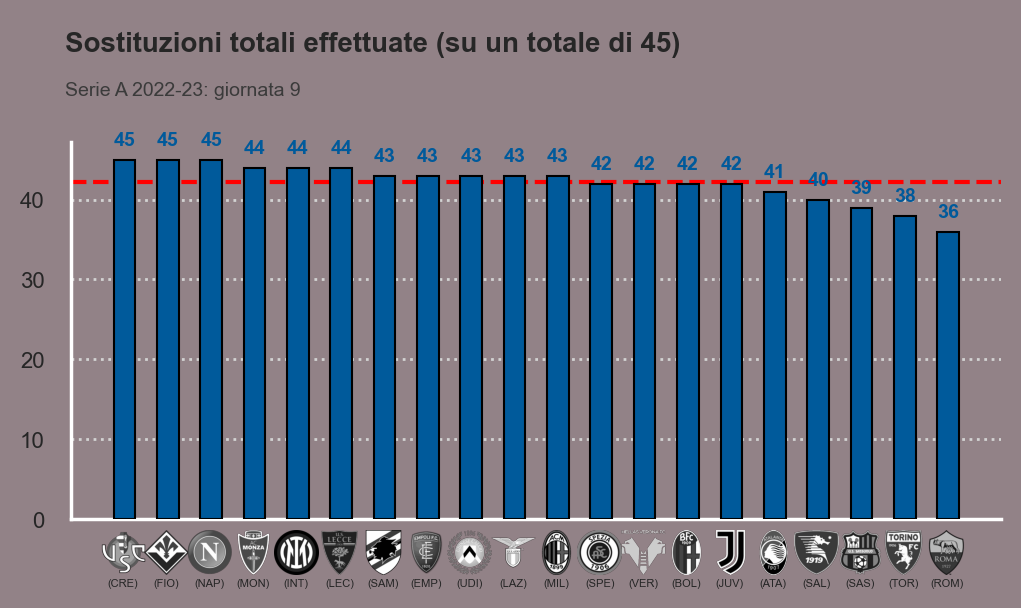

In [11]:
##### Different SUBS Plot Logic
def plotSUBS(team_SUBS, footTeams):
  team_substitutions = pd.merge(team_SUBS, footTeams, how = "left")
  team_substitutions['Colors'] = "#005a9b"
  team_substitutions.replace({
        "team":{
         'Fiorentina' : 'FIO', 'Milan':'MIL', 'Atalanta':'ATA', 'Bologna':'BOL', 'Cremonese':'CRE', 'Empoli':'EMP',
         'Hellas Verona':'VER', 'Internazionale':'INT', 'Juventus':'JUV', 'Lazio':'LAZ', 'Lecce':'LEC', 'Monza':'MON',
         'Roma':'ROM', 'Napoli':'NAP', 'Salernitana':'SAL', 'Sampdoria':'SAM', 'Sassuolo':'SAS', 'Spezia':'SPE',
         'Torino':'TOR', 'Udinese':'UDI', 'Genoa':'GEN', 'Cagliari':'CAG', 'Venezia':'VEN', 'Benevento':'BEN',
         'Crotone':'CRO', 'Parma':'PAR', 'Brescia':'BRE', 'Spal':'SPA',
         'Alessandria':'ALE', 'Ascoli':'ASC', 'Cittadella':'CIT', 'Como':'COM', 'Cosenza':'COS', 'Frosinone':'FRO',
         'Vicenza':'VIC', 'Perugia':'PER', 'Pisa':'PIS', 'Pordenone':'POR', 'Reggina':'REG', 'Ternana':'TER',
         'Pescara':'PES', 'Reggiana':'REA', 'Virtus Entella':'ENT', 'Chievo':'CHI', 'Juve Stabia':'STA', 'Livorno':'LIV', 'Trapani':'TRA'
        }}, inplace = True)
  team_substitutions.sort_values('totalSubs', ascending=False, ignore_index=True, inplace=True)
  team_substitutions_avg = team_substitutions['totalSubs'].mean()

  X_season = team_substitutions['team'].values
  height_season = team_substitutions['totalSubs'].values

  # EFE9E6
  fig = plt.figure(figsize=(6, 2.5), dpi = 200, facecolor = "#928287")
  ax = plt.subplot(111, facecolor = "#928287")
  # Add spines
  ax.spines["top"].set(visible = False)
  ax.spines["right"].set(visible = False)
  # Add grid and axis labels
  ax.grid(True, color = "lightgrey", ls = ":")
  # We specify the width of the bar
  width = 0.5

  # Different LineUps
  ax.bar(
    X_season, 
    height_season, 
    ec = "black", 
    lw = .75, 
    color = team_substitutions['Colors'], 
    zorder = 3, 
    width = width,
    label = "# Sostituzioni"
  )
  ax.axhline(y=team_substitutions_avg, color='red', linestyle='--', label='average')
  for index, y in enumerate(height_season):
    ax.annotate(
        xy = (index, y),
        text = f"{y:.0f}",
        xytext = (0, 7),
        textcoords = "offset points",
        size = 7,
        color = "#005a9b",
        ha = "center",
        va = "center",
        weight = "bold"
    )

  xticks_ = ax.xaxis.set_ticks(
    ticks = []
  )
  ax.tick_params(labelsize = 8)
  # --- Axes transformations
  DC_to_FC = ax.transData.transform
  FC_to_NFC = fig.transFigure.inverted().transform

  # Native data to normalized data coordinates
  DC_to_NFC = lambda x: FC_to_NFC(DC_to_FC(x))

  fotmob_url = "https://images.fotmob.com/image_resources/logo/teamlogo/"
  for index, team_id in enumerate(team_substitutions["footId"]):
    ax_coords = DC_to_NFC([index - 1.1*width, -7])
    logo_ax = fig.add_axes([ax_coords[0], ax_coords[1], 0.09, 0.09], anchor = "W")
    club_icon = Image.open(urllib.request.urlopen(f"{fotmob_url}{team_id:.0f}.png")).convert("LA")
    logo_ax.imshow(club_icon)
    logo_ax.axis("off")
    logo_ax.annotate(
        xy =(0, 0),
        text = f"({team_substitutions['team'].iloc[index]})",
        xytext = (8, -19),
        textcoords = "offset points",
        size = 4,
        ha = "center",
        va = "center"
    )

  fig_text(
    x = 0.12, y = 1.1,
    s = "Sostituzioni totali effettuate (su un totale di 45)",
    weight = "bold",
    size = 10
  )
  title = "Serie A 2022-23: giornata 9"
  fig_text(
    x = 0.12, y = 1,
    s = title,
    color = "#3b3b3b",
    size = 7
  )

  filename = "../figures/Totale_Sostituzioni_SerieA_22_23_giornata9.png"
  plt.savefig(
	  filename,
	  dpi = 600,
	  facecolor = "#928287",
	  bbox_inches="tight",
    edgecolor="none",
	  transparent = False
  )

plotSUBS(df_subscount,footTeams)

In [6]:
df_subs_ordered = df_subs.groupby('team').median().sort_values(by='minuto', ascending=False)
df_subs_ordered_list = list(df_subs_ordered.index)

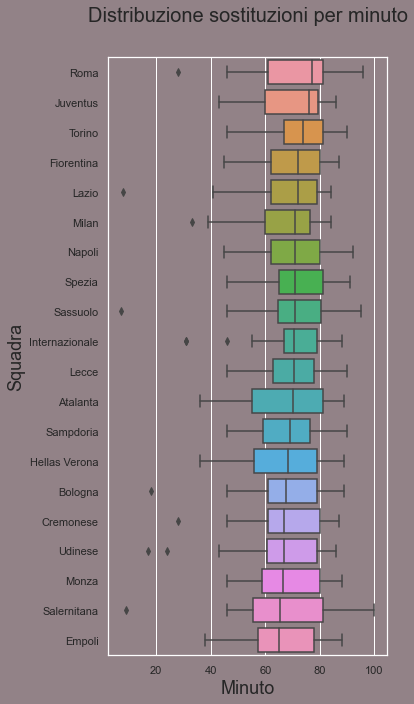

In [10]:
fig, box = plt.subplots(figsize=(5, 11))
box = sns.boxplot(data=df_subs, x="minuto", y="team", orient="h", order=df_subs_ordered_list)
sns.set(rc={'axes.facecolor':'#928287', 'figure.facecolor':'#928287'})
box.set_title("Distribuzione sostituzioni per minuto",fontdict= { 'fontsize': 20}, y=1.05)
box.set_xlabel('Minuto',fontsize = 18)
box.set_ylabel('Squadra',fontsize = 18)
#box.set_xticklabels(labels, rotation=30 );
filename = "../figures/Distribuzione_Sostituzioni_SerieA_22_23_giornata9.png"
plt.savefig(
	  filename,
	  dpi = 600,
	  facecolor = "#928287",
	  bbox_inches="tight",
      edgecolor="none",
	  transparent = False
  )
plt.show()

In [8]:
team_goal_substitutions = pd.merge(df, footTeams, how = "left")
team_goal_substitutions.loc[:,'totalGoal'] = team_goal_substitutions.loc[:, 'goalSubs'] + team_goal_substitutions.loc[:, 'goalSubsDec']
team_goal_substitutions = team_goal_substitutions.sort_values(by='totalGoal', ascending=False).reset_index(drop=True)

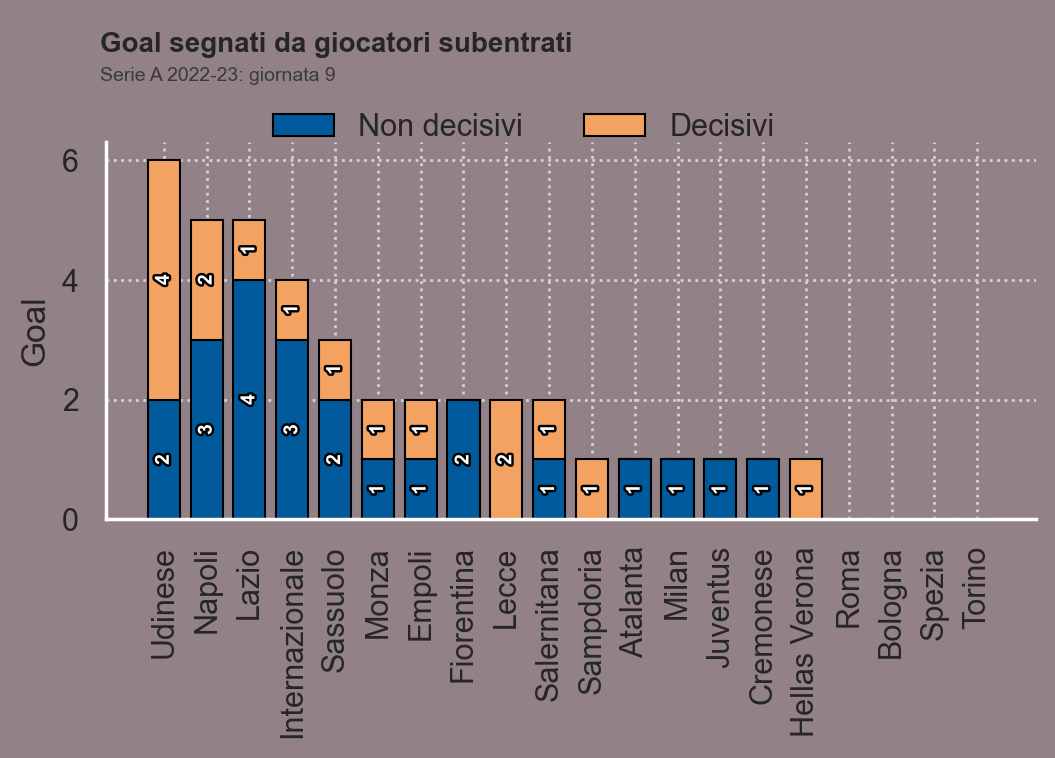

In [9]:
height_n = (
    team_goal_substitutions["goalSubs"]
    .reset_index(drop = True)
)

height_d = (
    team_goal_substitutions["goalSubsDec"]
    .reset_index(drop = True)
)

# We'll annotate the x-axis differently.
X = np.arange(len(height_n))

sort_order = team_goal_substitutions["team"].to_list()

width = 0.5
fig = plt.figure(figsize=(6, 2.5), dpi = 200, facecolor = "#928287")
ax = plt.subplot(111, facecolor = "#928287")

# Add spines
ax.spines["top"].set(visible = False)
ax.spines["right"].set(visible = False)

# Add grid and axis labels
ax.grid(True, color = "lightgrey", ls = ":")
ax.set_ylabel("Goal")

# offensive SB
ax.bar(
    X, 
    height_n, 
    ec = "black", 
    lw = .75, 
    color = "#005a9b", 
    zorder = 2, 
    width = 0.75,
    label = "Non decisivi"
)

# defensive SB
ax.bar(
    X, 
    height_d,
    bottom = height_n, # This creates the stacked chart 
    ec = "black", 
    lw = .75, 
    color = "#f4a261", 
    zorder = 2, 
    width = 0.75,
    label = "Decisivi"
)

ax.legend(
    ncol = 2, 
    loc = "upper center", 
    bbox_to_anchor = (0.45, 1.15),
    frameon = False
)

# Annotate the bar chart
aux_counter = 0
for y_n, y_d in zip(height_n, height_d):
    # annotate percentage of fouls in the center of the bar
    if (y_n!=0):
        home_text = ax.annotate(
            xy = (aux_counter, y_n/2),
            text = f"{y_n}", # F-strings are cool :)
            size = 7,
            ha = "center",
            va = "center",
            weight = "bold",
            color = "white",
            rotation = 90
        )

    if (y_d!=0):
        away_text = ax.annotate(
            xy = (aux_counter, y_n + y_d/2), # Notice the sum of the bottom data.
            text = f"{y_d}",
            size = 7,
            ha = "center",
            va = "center",
            weight = "bold",
            color = "white",
            rotation = 90
        )

    home_text.set_path_effects(
        [path_effects.Stroke(linewidth=1.75, foreground="black"), path_effects.Normal()]
    )

    away_text.set_path_effects(
        [path_effects.Stroke(linewidth=1.75, foreground="black"), path_effects.Normal()]
    )

    aux_counter += 1


# Adjust ticks
xticks_ = ax.xaxis.set_ticks(
    ticks = X,
    labels = sort_order,
    rotation = 90
)
  
fig_text(
    x = 0.12, y = 1.1,
    s = "Goal segnati da giocatori subentrati",
    weight = "bold",
    size = 10
)
title = "Serie A 2022-23: giornata 9"
fig_text(
    x = 0.12, y = 1.03,
    s = title,
    color = "#3b3b3b",
    size = 7
)

filename = "../figures/Goal_da_Sostituzioni_SerieA_22_23_giornata9.png"
plt.savefig(
	  filename,
	  dpi = 600,
	  facecolor = "#928287",
	  bbox_inches="tight",
      edgecolor="none",
	  transparent = False
  )
plt.show()